In [28]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
%pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model  
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

**Loading The Dataset**

In [3]:
# Set up paths and parameters
data_dir = "D:\edai-6"  # Replace with your dataset path
images_dir = os.path.join(data_dir, "Images") 
annotations_dir = os.path.join(data_dir, "Annotations")
style_image_path = "D:\edai-6\Monet.jpg"  # Your style image
output_dir = "D:\\edai-6\\Stylized_Output"
os.makedirs(output_dir, exist_ok=True)

In [4]:
IMG_SIZE = 256
BATCH_SIZE = 1
TEMPORAL_WEIGHT = 0.1  # Weight for temporal consistency loss
CONTENT_WEIGHT = 1e4
STYLE_WEIGHT = 1e10
CONTENT_LAYERS = ['block5_conv2']  # VGG19 layers for content
STYLE_LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [5]:
classes = sorted(os.listdir(images_dir))
print(f"Total number of classes in Images: {len(classes)}")
for class_name in classes:
    print(class_name)

Total number of classes in Images: 90
bear
bike-packing
blackswan
bmx-bumps
bmx-trees
boat
boxing-fisheye
breakdance
breakdance-flare
bus
camel
car-roundabout
car-shadow
car-turn
cat-girl
classic-car
color-run
cows
crossing
dance-jump
dance-twirl
dancing
disc-jockey
dog
dog-agility
dog-gooses
dogs-jump
dogs-scale
drift-chicane
drift-straight
drift-turn
drone
elephant
flamingo
goat
gold-fish
hike
hockey
horsejump-high
horsejump-low
india
judo
kid-football
kite-surf
kite-walk
koala
lab-coat
lady-running
libby
lindy-hop
loading
longboard
lucia
mallard-fly
mallard-water
mbike-trick
miami-surf
motocross-bumps
motocross-jump
motorbike
night-race
paragliding
paragliding-launch
parkour
pigs
planes-water
rallye
rhino
rollerblade
schoolgirls
scooter-black
scooter-board
scooter-gray
sheep
shooting
skate-park
snowboard
soapbox
soccerball
stroller
stunt
surf
swing
tennis
tractor-sand
train
tuk-tuk
upside-down
varanus-cage
walking


In [6]:
annot_classes = sorted(os.listdir(annotations_dir))
print(f"Total number of classes in Image Annotations: {len(annot_classes)}")
for annot_name in annot_classes:
    print(annot_name)

Total number of classes in Image Annotations: 90
bear
bike-packing
blackswan
bmx-bumps
bmx-trees
boat
boxing-fisheye
breakdance
breakdance-flare
bus
camel
car-roundabout
car-shadow
car-turn
cat-girl
classic-car
color-run
cows
crossing
dance-jump
dance-twirl
dancing
disc-jockey
dog
dog-agility
dog-gooses
dogs-jump
dogs-scale
drift-chicane
drift-straight
drift-turn
drone
elephant
flamingo
goat
gold-fish
hike
hockey
horsejump-high
horsejump-low
india
judo
kid-football
kite-surf
kite-walk
koala
lab-coat
lady-running
libby
lindy-hop
loading
longboard
lucia
mallard-fly
mallard-water
mbike-trick
miami-surf
motocross-bumps
motocross-jump
motorbike
night-race
paragliding
paragliding-launch
parkour
pigs
planes-water
rallye
rhino
rollerblade
schoolgirls
scooter-black
scooter-board
scooter-gray
sheep
shooting
skate-park
snowboard
soapbox
soccerball
stroller
stunt
surf
swing
tennis
tractor-sand
train
tuk-tuk
upside-down
varanus-cage
walking


In [7]:
# Select a class (video sequence) to load
class_name = classes[1]  # Example: 'bear'
class_image_dir = os.path.join(images_dir, class_name)
class_annotation_dir = os.path.join(annotations_dir, class_name)

In [8]:
frames = sorted([f for f in os.listdir(class_image_dir) if f.endswith('.jpg')])
masks = sorted([f for f in os.listdir(class_annotation_dir) if f.endswith('.png')])

In [9]:
# Load and visualize the first frame and its annotation
frame_path = os.path.join(class_image_dir, frames[1])
mask_path = os.path.join(class_annotation_dir, masks[1])

In [10]:
frame = cv2.imread(frame_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

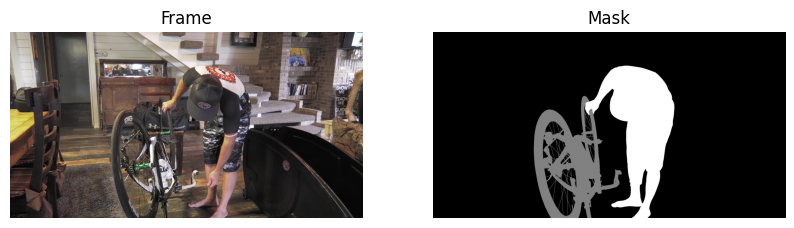

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Frame")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()

In [12]:
# Load train and validation splits
image_sets_dir  = "D:\\edai-6\\ImageSets\\2017"
train_file = os.path.join(image_sets_dir, "train.txt")
val_file = os.path.join(image_sets_dir, "val.txt")

In [13]:
with open(train_file, "r") as f:
    train_classes = f.read().splitlines()

with open(val_file, "r") as f:
    val_classes = f.read().splitlines()

In [14]:
print(f"Number of training classes: {len(train_classes)}")
print(f"Number of validation classes: {len(val_classes)}")

Number of training classes: 60
Number of validation classes: 30


In [15]:
def load_class_data(class_name):
    class_image_dir = os.path.join(images_dir, class_name)
    class_annotation_dir = os.path.join(annotations_dir, class_name)

    # Load all frames and annotations
    frames = sorted(os.listdir(class_image_dir))
    masks = sorted(os.listdir(class_annotation_dir))

    # Load images and masks
    images = [cv2.imread(os.path.join(class_image_dir, frame)) for frame in frames]
    masks = [cv2.imread(os.path.join(class_annotation_dir, mask), cv2.IMREAD_GRAYSCALE) for mask in masks]

    return images, masks

In [16]:
train_class_name = train_classes[0]  # Example: First training class
train_images, train_masks = load_class_data(train_class_name)

In [17]:
val_class_name = val_classes[0]  # Example: First validation class
val_images, val_masks = load_class_data(val_class_name)

In [18]:
print(f"Number of frames in training class '{train_class_name}': {len(train_images)}")
print(f"Number of frames in validation class '{val_class_name}': {len(val_images)}")

Number of frames in training class 'bear': 82
Number of frames in validation class 'bike-packing': 69


In [19]:
from tensorflow.keras.utils import register_keras_serializable

In [20]:
@register_keras_serializable(package='Custom', name='hybrid_loss')
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)

def hybrid_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice

In [21]:
@register_keras_serializable(package='Custom', name='iou_metric')
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersect
    iou = intersect / (union + 1e-7)
    return tf.reduce_mean(iou)

In [23]:
unet_model_path = "D:/edai-6/unet_davis2017.h5"
unet_model = tf.keras.models.load_model(
    unet_model_path,
    custom_objects={
        'hybrid_loss': hybrid_loss,  # Include the loss
        'iou_metric': iou_metric     # Include the metric
    }
)

In [24]:
# Function to preprocess frame for U-Net and predict mask
def predict_mask(frame, model, size=IMG_SIZE):
    # Preprocess frame: Normalize and resize to match U-Net input
    frame = frame.astype(np.float32) / 255.0
    frame = cv2.resize(frame, (size, size))
    frame = frame[np.newaxis, ...]  # Add batch dimension (1, 256, 256, 3)
    
    # Predict mask using U-Net
    mask = model.predict(frame, verbose=0)
    mask = mask.squeeze()  # Remove batch dimension (256, 256, 1)
    
    # Post-process mask: Threshold to binary and ensure correct shape
    mask = (mask > 0.5).astype(np.float32)
    mask = mask[..., np.newaxis]  # Ensure shape (256, 256, 1)
    
    # Debug: Print foreground pixels to verify prediction
    print(f"Foreground pixels in predicted mask: {np.sum(mask)}")
    
    return mask

**Build VGG19 model for feature extraction**

In [25]:
def build_vgg_model():
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in (CONTENT_LAYERS + STYLE_LAYERS)]
    model = Model(vgg.input, outputs)
    return model

In [26]:
def preprocess_image(image):
    """Preprocess image for VGG19."""
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.vgg19.preprocess_input(image * 255.0)
    return image

In [27]:
def load_image_cv2(image_path, size=IMG_SIZE):
    """Load and preprocess image using OpenCV."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (size, size))
    image = image.astype(np.float32) / 255.0
    return image

In [28]:
# Function to load ground-truth mask
def load_mask(mask_path, size=IMG_SIZE):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (size, size))
    mask = (mask > 0).astype(np.float32)
    mask = mask[..., np.newaxis]
    
    # # Debug: Print foreground pixels and save mask for visualization
    # print(f"Foreground pixels in ground-truth mask: {np.sum(mask)}")
    # mask_to_save = (mask.squeeze() * 255).astype(np.uint8)
    # mask_filename = os.path.basename(mask_path)
    # mask_save_path = os.path.join(output_dir, f"ground_truth_mask_{mask_filename}")
    # cv2.imwrite(mask_save_path, mask_to_save)
    # print(f"Saved ground-truth mask at {mask_save_path}")
    
    return mask

In [29]:
def compute_gram_matrix(feature_maps):
    """Compute Gram matrix for style loss."""
    batch, height, width, channels = feature_maps.shape
    features = tf.reshape(feature_maps, (batch, height * width, channels))
    gram = tf.matmul(features, features, transpose_a=True)
    return gram / (height * width * channels)

In [30]:
def compute_content_loss(content_features, generated_features):
    """Compute content loss."""
    return tf.reduce_mean(tf.square(content_features - generated_features))

In [31]:
def compute_style_loss(style_features, generated_features):
    """Compute style loss using Gram matrices."""
    style_gram = compute_gram_matrix(style_features)
    generated_gram = compute_gram_matrix(generated_features)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))

In [32]:
def compute_optical_flow(prev_frame, curr_frame):
    """Compute optical flow between two frames."""
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

In [33]:
def warp_image(image, flow):
    """Warp image using optical flow."""
    h, w = image.shape[:2]
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    flow_map = np.stack([x + flow[..., 0], y + flow[..., 1]], axis=-1)
    warped = cv2.remap(image, flow_map.astype(np.float32), None, cv2.INTER_LINEAR)
    return warped

In [34]:
def temporal_consistency_loss(stylized_curr, stylized_prev, flow):
    """Compute temporal consistency loss."""
    stylized_prev = stylized_prev.numpy().squeeze() if isinstance(stylized_prev, tf.Tensor) else stylized_prev
    warped_prev = warp_image(stylized_prev, flow)
    warped_prev = tf.convert_to_tensor(warped_prev, dtype=tf.float32)
    diff = tf.reduce_mean(tf.abs(stylized_curr - warped_prev))
    return TEMPORAL_WEIGHT * diff

In [35]:
def segmentation_guided_style(content_image, style_image, mask, vgg_model, prev_stylized=None, flow=None, background_style_image=None):
    """Apply style transfer with segmentation guidance and temporal consistency."""
    content_image = tf.convert_to_tensor(content_image, dtype=tf.float32)
    style_image = tf.convert_to_tensor(style_image, dtype=tf.float32)
    mask = tf.convert_to_tensor(mask, dtype=tf.float32)
    
    # Initialize generated image as a variable
    generated_image = tf.Variable(content_image, dtype=tf.float32)
    
    # Preprocess inputs for VGG
    content_input = preprocess_image(content_image)
    style_input = preprocess_image(style_image)
    generated_input = preprocess_image(generated_image)
    
    # Get VGG features for each input separately
    content_outputs = vgg_model(content_input)
    style_outputs = vgg_model(style_input)
    generated_outputs = vgg_model(generated_input)
    
    # Split features into content and style
    content_features = content_outputs[:len(CONTENT_LAYERS)]
    style_features = style_outputs[len(CONTENT_LAYERS):]
    generated_features = generated_outputs[:len(CONTENT_LAYERS)] + generated_outputs[len(CONTENT_LAYERS):]
    
    # Compute losses
    content_loss = sum(compute_content_loss(content_features[i], generated_features[i]) 
                       for i in range(len(CONTENT_LAYERS)))
    style_loss = sum(compute_style_loss(style_features[i], generated_features[i + len(CONTENT_LAYERS)]) 
                     for i in range(len(STYLE_LAYERS)))
    
    total_loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss
    
    # Temporal consistency
    if prev_stylized is not None and flow is not None:
        temporal_loss = temporal_consistency_loss(generated_image, prev_stylized, flow)
        total_loss += temporal_loss
    
    # Optimize
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
    @tf.function
    def train_step():
        with tf.GradientTape() as tape:
            generated_input = preprocess_image(generated_image)
            generated_outputs = vgg_model(generated_input)
            gen_content = generated_outputs[:len(CONTENT_LAYERS)]
            gen_style = generated_outputs[len(CONTENT_LAYERS):]
            c_loss = sum(compute_content_loss(content_features[i], gen_content[i]) 
                         for i in range(len(CONTENT_LAYERS)))
            s_loss = sum(compute_style_loss(style_features[i], gen_style[i]) 
                         for i in range(len(STYLE_LAYERS)))
            loss = CONTENT_WEIGHT * c_loss + STYLE_WEIGHT * s_loss
            if prev_stylized is not None and flow is not None:
                t_loss = temporal_consistency_loss(generated_image, prev_stylized, flow)
                loss += t_loss
        grads = tape.gradient(loss, generated_image)
        optimizer.apply_gradients([(grads, generated_image)])
        return loss
    
    # Run optimization
    for _ in range(100):  # Adjust iterations as needed
        train_step()
    
    # Segmentation-guided blending
    fg_stylized = generated_image
    if background_style_image is not None:
        bg_stylized = segmentation_guided_style(content_image, background_style_image, mask, vgg_model, prev_stylized, flow)
    else:
        bg_stylized = content_image  # Preserve original background
    stylized_image = mask * fg_stylized + (1 - mask) * bg_stylized
    
    return tf.clip_by_value(stylized_image, 0, 1)

In [36]:
# Updated process_video_sequence to use ground-truth masks
def process_video_sequence(class_name, style_image_path, max_frames=85):
    class_image_dir = os.path.join(images_dir,  class_name)
    class_annotation_dir = os.path.join(annotations_dir, class_name)
    frames = sorted([f for f in os.listdir(class_image_dir) if f.endswith('.jpg')])[:max_frames]
    masks = sorted([f for f in os.listdir(class_annotation_dir) if f.endswith('.png')])[:max_frames]
    
    # Ensure frames and masks align
    assert len(frames) == len(masks), f"Mismatch between frames ({len(frames)}) and masks ({len(masks)})"
    
    style_image = load_image_cv2(style_image_path)
    style_image = style_image[np.newaxis, ...]
    vgg_model = build_vgg_model()
    stylized_frames = []
    prev_stylized = None
    
    for i, (frame_file, mask_file) in enumerate(zip(frames, masks)):
        print(f"Processing frame {i+1}/{len(frames)}")
        content_path = os.path.join(class_image_dir, frame_file)
        mask_path = os.path.join(class_annotation_dir, mask_file)
        
        content_image = load_image_cv2(content_path)
        content_image = content_image[np.newaxis, ...]
        content_cv2 = load_image_cv2(content_path)
        
        # Load ground-truth mask
        mask = load_mask(mask_path)
        
        flow = None
        if prev_stylized is not None:
            prev_cv2 = stylized_frames[-1].numpy().squeeze()
            flow = compute_optical_flow(prev_cv2, content_cv2)
        stylized_image = segmentation_guided_style(content_image, style_image, mask, vgg_model, prev_stylized, flow)
        stylized_frames.append(stylized_image)
        prev_stylized = stylized_image
    return stylized_frames, frames

In [37]:
def save_video(stylized_frames, frame_files, class_name, output_dir=output_dir):
    """Save stylized frames as a video."""
    output_path = os.path.join(output_dir, f"{class_name}_stylized.mp4")
    h, w = IMG_SIZE, IMG_SIZE
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (w, h))
    
    for frame in stylized_frames:
        frame_np = frame.numpy().squeeze()
        frame_np = np.clip(frame_np, 0, 1) * 255
        frame_np = frame_np.astype(np.uint8)
        frame_np = cv2.cvtColor(frame_np, cv2.COLOR_RGB2BGR)
        out.write(frame_np)
    
    out.release()
    print(f"Video saved at {output_path}")

Processing frame 1/70
Processing frame 2/70
Processing frame 3/70
Processing frame 4/70
Processing frame 5/70
Processing frame 6/70
Processing frame 7/70
Processing frame 8/70
Processing frame 9/70
Processing frame 10/70
Processing frame 11/70
Processing frame 12/70
Processing frame 13/70
Processing frame 14/70
Processing frame 15/70
Processing frame 16/70
Processing frame 17/70
Processing frame 18/70
Processing frame 19/70
Processing frame 20/70
Processing frame 21/70
Processing frame 22/70
Processing frame 23/70
Processing frame 24/70
Processing frame 25/70
Processing frame 26/70
Processing frame 27/70
Processing frame 28/70
Processing frame 29/70
Processing frame 30/70
Processing frame 31/70
Processing frame 32/70
Processing frame 33/70
Processing frame 34/70
Processing frame 35/70
Processing frame 36/70
Processing frame 37/70
Processing frame 38/70
Processing frame 39/70
Processing frame 40/70
Processing frame 41/70
Processing frame 42/70
Processing frame 43/70
Processing frame 44/

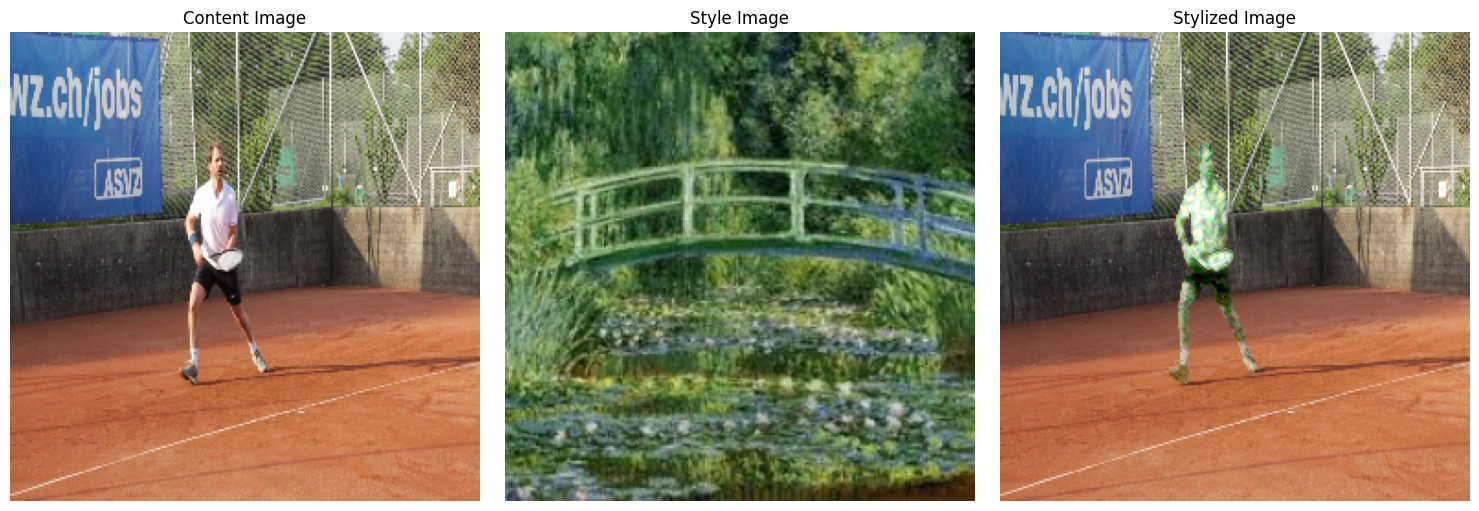

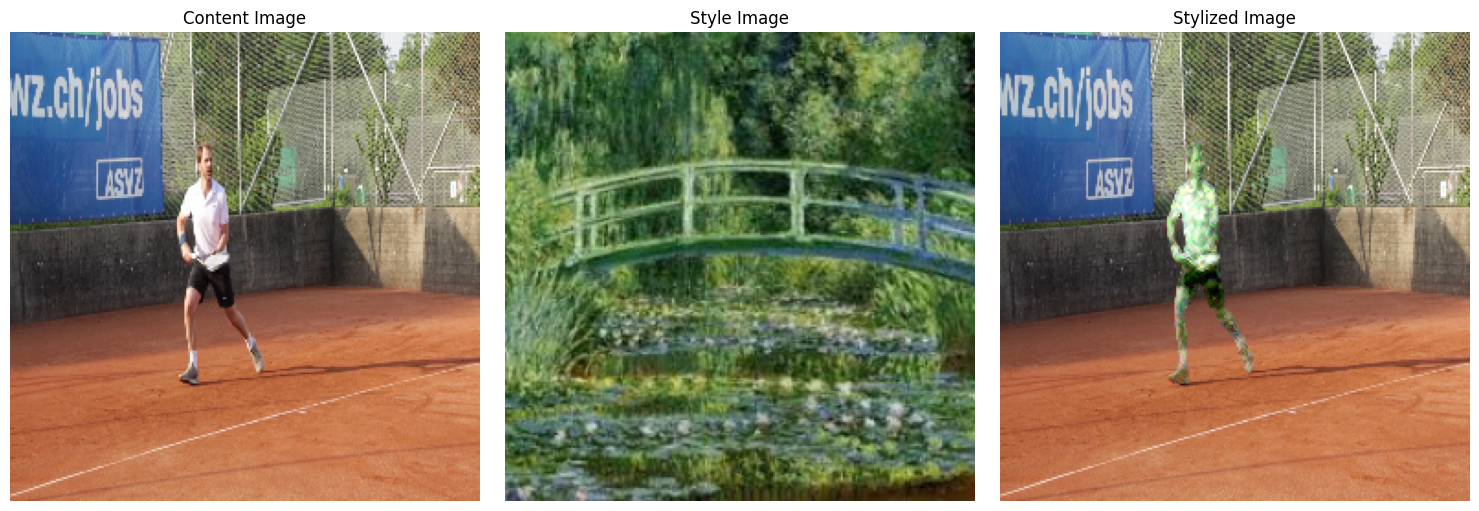

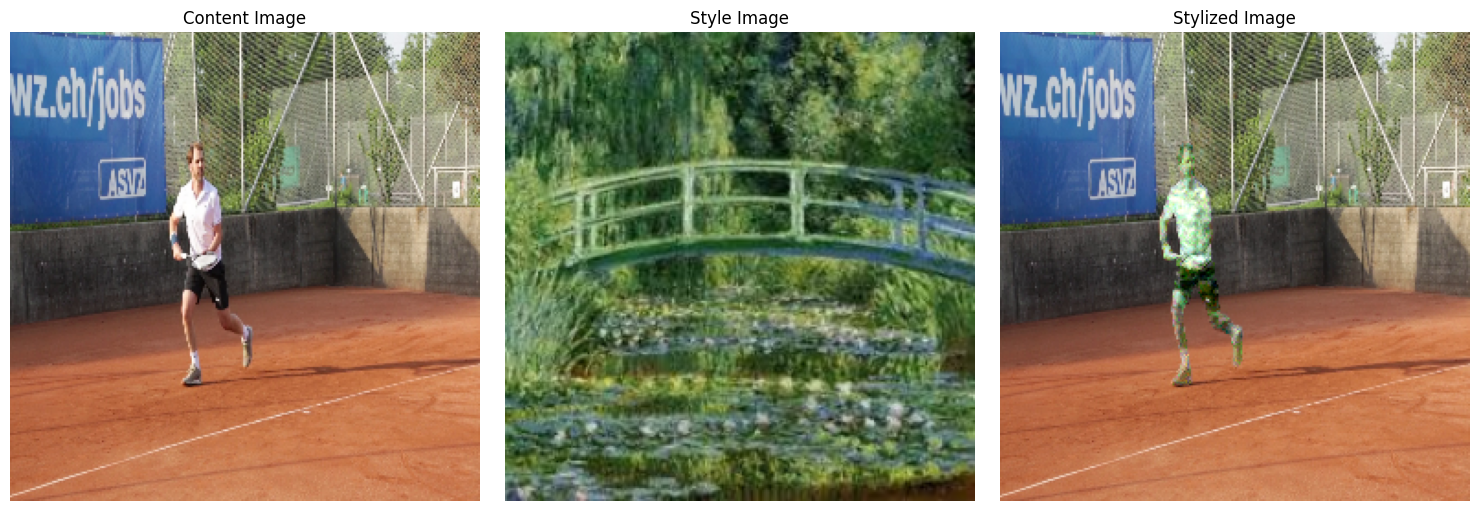

In [39]:
def display_results(stylized_frames, content_frames, style_image, class_name):
    """Display original and stylized frames."""
    style_display = style_image.squeeze()
    
    for i, (stylized, content_file) in enumerate(zip(stylized_frames[:3], content_frames[:3])):
        content_path = os.path.join(images_dir, class_name, content_file)
        content_display = load_image_cv2(content_path)
        stylized_display = stylized.numpy().squeeze()
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(content_display)
        plt.title("Content Image")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(style_display)
        plt.title("Style Image")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(stylized_display)
        plt.title("Stylized Image")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == "__main__":
    class_name = "tennis"
    stylized_frames, frame_files = process_video_sequence(class_name, style_image_path, max_frames=85)
    save_video(stylized_frames, frame_files, class_name)
    style_image = load_image_cv2(style_image_path)
    style_image = style_image[np.newaxis, ...]
    display_results(stylized_frames, frame_files, style_image, class_name)

In [ ]:
D:\edai-6\Images\bear
D:\edai-6\Images\bear\00000.jpg